# Solar Power Generation Forecast

## About the Dataset
[This dataset](https://www.kaggle.com/datasets/anikannal/solar-power-generation-data) consists of solar power generation and sensor reading data that have been gathered at two solar power plants in India over a 34 day period. We use the dataset collected at Plant 1. According to the dataset documentation, "the power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant"

Our goal is to forecast the amount of DC power generated in a day from 9 am to 8 pm with a 1 hour resolution, based on previous observations. We will use ARIMA, multilayer perceptron, and LSTM, and compare their performance. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import OCSBTest, auto_arima, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import pickle
import torch
import torch.nn as nn
import torch.utils.data as tdata
from sklearn.metrics import mean_squared_error


First, we load the power generation data. 

In [2]:
df_power = pd.read_csv('Plant_1_Generation_Data.csv')
df_power.head()


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


The folowing describes each column:

![](columns_power.png)

We load the sensor reading data. 

In [3]:
df_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
df_weather.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


The folowing describes each column:

![](columns_weather.png)

Next, we remove the plant ID from datasets and source key from the sensor reading dataset, as these are common for the entire files. We also remove AC power, daily yield, and total yield as they are not useful for our purpose. We also covert the type of date-time from string to datetime objects and rename interver IDs.

In [4]:
#Drop unnecessary columns 
df_power = df_power.drop(columns = ['PLANT_ID', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']) 
df_weather = df_weather.drop(columns = ['PLANT_ID', 'SOURCE_KEY'])

#Rename SOURCE_KEY to INVERTER_ID and asssign inventors IDs from INV0 to INV21. 
df_power = df_power.rename(columns = {'SOURCE_KEY':'INVERTER_ID'})
unique_id = pd.unique(df_power['INVERTER_ID'])
id_hm = { unique_id [i]: f'INV{i}' for i in range(len(unique_id))}
df_power['INVERTER_ID'] = df_power['INVERTER_ID'].map(id_hm)

#Convert DATE_TIME values from string to datetime
df_weather['DATE_TIME'] = pd.to_datetime(df_weather.DATE_TIME, format='%Y-%m-%d %H:%M:%S')
df_power['DATE_TIME'] = pd.to_datetime(df_power.DATE_TIME, format='%d-%m-%Y %H:%M')

## Some Exploratory Data Analysis 

Let's plot the total DC power generation by the plant in each 15 minute interval.

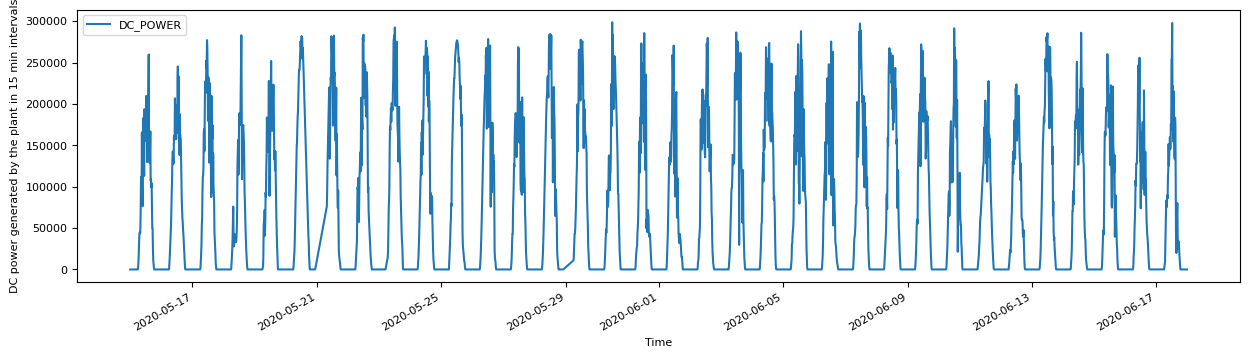

In [5]:
df_avg_power = df_power.groupby ('DATE_TIME').sum(numeric_only = True).reset_index()

plt.rc('figure',figsize=(15,4))
plt.rc('font',size=8)
df_avg_power.plot(x = 'DATE_TIME', y = 'DC_POWER')
plt.xlabel('Time')
plt.ylabel('DC power generated by the plant in 15 min intervals')
plt.show()

Next, we check if any data is missing. Note that there must be 71808 many timestamps power generation data in the (3264 timestamps for each inverter) and 3264 timestampsin the sensor reading data. 

In [6]:
pd.isna(df_power).any()

DATE_TIME      False
INVERTER_ID    False
DC_POWER       False
dtype: bool

In [7]:
len(df_power)

68778

So, the power generation data has no NaN but about 4.3% of timestamps are missing. 

In [8]:
pd.isna(df_weather).any()

DATE_TIME              False
AMBIENT_TEMPERATURE    False
MODULE_TEMPERATURE     False
IRRADIATION            False
dtype: bool

In [9]:
len(df_weather)

3182

Similarly, the sensor reading data has no NaN but about 2.5% of timestamps are missing.

To make working with the data simpler, we reshape the power generation dataset so that there a column for each inverter. 

In [10]:
df_power = df_power.pivot (index = 'DATE_TIME', columns = 'INVERTER_ID', values = 'DC_POWER')
hm = { f'INV{i}': f'DC_POWER_{i}' for i in range(22)}
df_power = df_power.rename ( columns = hm)
df_power = df_power.reset_index()
df_power.columns.name = None

We also add a row for each missing timestamp in the power generation dataset and the sensor reading dataset.

In [11]:
date_times = pd.Series(pd.date_range(df_power.DATE_TIME.min(), df_power.DATE_TIME.max(), freq='15min'), name='DATE_TIME').to_frame()

df_power = date_times.merge (df_power, how = 'left', on = 'DATE_TIME')
df_weather = date_times.merge (df_weather, how = 'left', on = 'DATE_TIME')

We plot the number of inverteres with missing data in each timestamps.

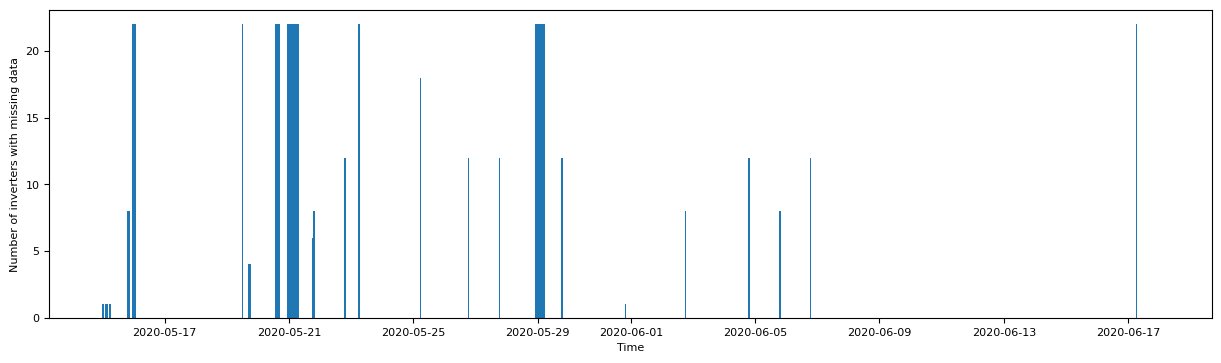

In [12]:
num_nans = pd.isna(df_power).sum(axis=1)
plt.bar(df_power['DATE_TIME'], num_nans, width=0.01)
plt.xlabel('Time')
plt.ylabel('Number of inverters with missing data')
plt.show()

It seems that missing appears in consequative time intervals. 

We also plot the number of timestamps in which each inverter is missing data.

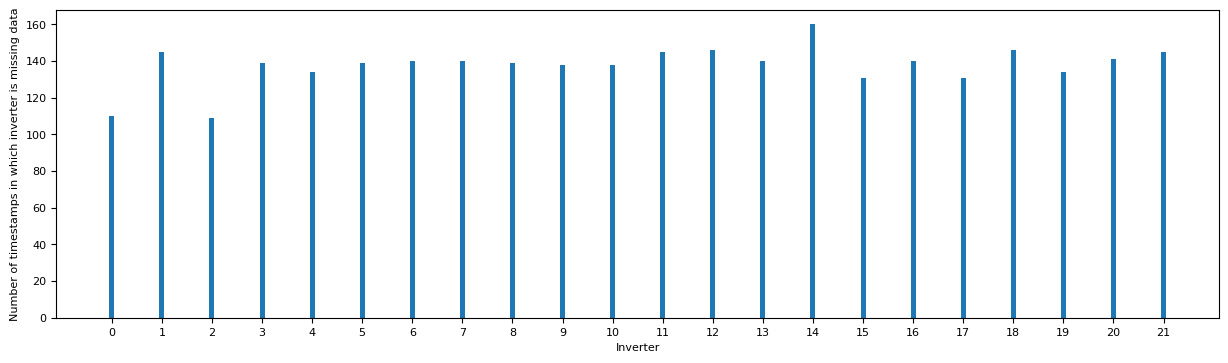

In [13]:
num_nans = pd.isna(df_power).sum(axis=0)[1:]
plt.bar(range(22), num_nans, width=0.1)
plt.xlabel('Inverter')
plt.xticks(range(22))
plt.ylabel('Number of timestamps in which inverter is missing data')
plt.show()

Also the missing data is almost uniform among the inverters. We will impute the data later. 

Let's also plot the distribution of DC power generated by each inverter in a day. Note that there are 34*22 points for each 15 min time interval.

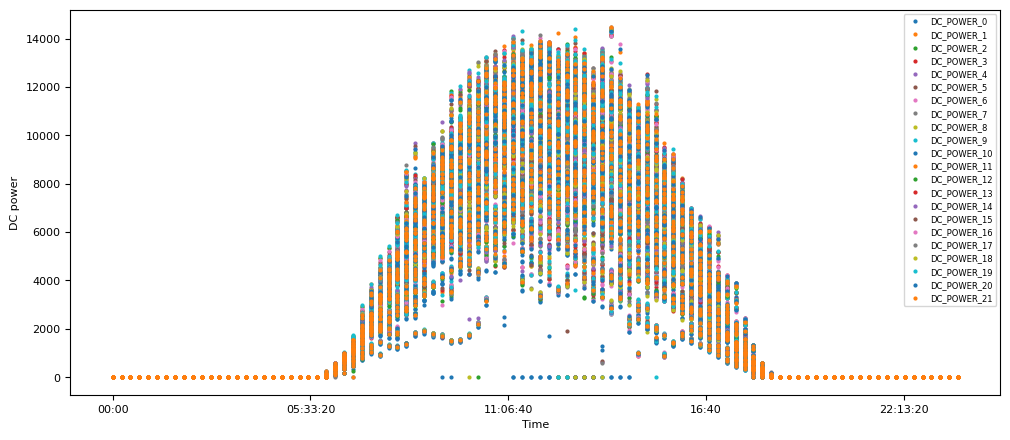

In [14]:
def daily_scatter_plot(df_in, draw_percentile = False, percentile = 5):
    df_in ['time'] = df_in ['DATE_TIME'].dt.time
    fig, axs = plt.subplots(figsize=(12, 5)) 
    plt.rc('font',size=5.5)
    for i in range (22):
        df_in.plot(x = 'time', y = f'DC_POWER_{i}', ax = axs, style = 'o',  markersize=2)
    if draw_percentile:
            df_percentile_low  = df_in.groupby(['time']).quantile(percentile /100).mean(axis = 1, numeric_only=True).reset_index()
            df_percentile_low.columns = ['time', f'{percentile}th percentile']
            df_percentile_low.plot(x ='time', y = f'{percentile}th percentile', ax = axs, label = f'{percentile}th percentile of DC power generation')
    plt.xlabel('Time')
    plt.ylabel('DC power')
    plt.legend(fontsize=6)
    df_in.drop(columns = ['time'], inplace = True)
    return axs


axs = daily_scatter_plot(df_power, False)
plt.show()

To learn more about the outliers, we compare the distribution of power generation data with the distribution of irradiance. We compare the overall appearance of plots and the 5th percentile of the power generation in each interval (among all inverters) with those of irradiation in the interval.

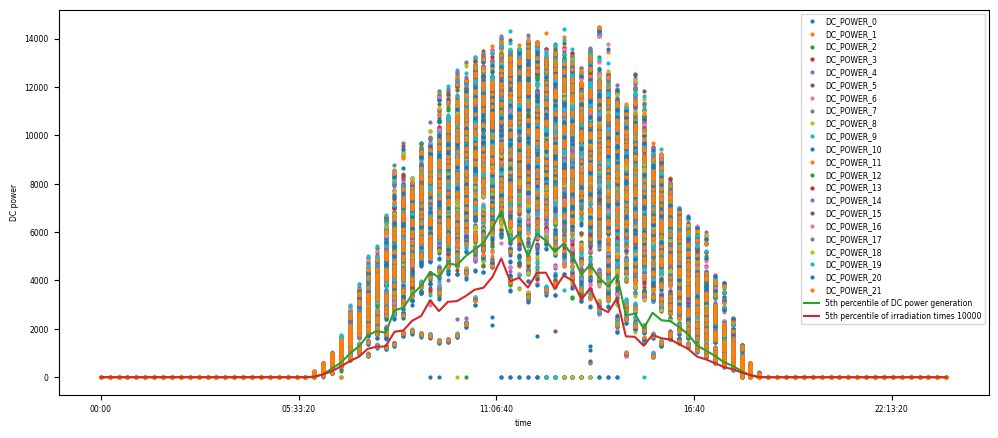

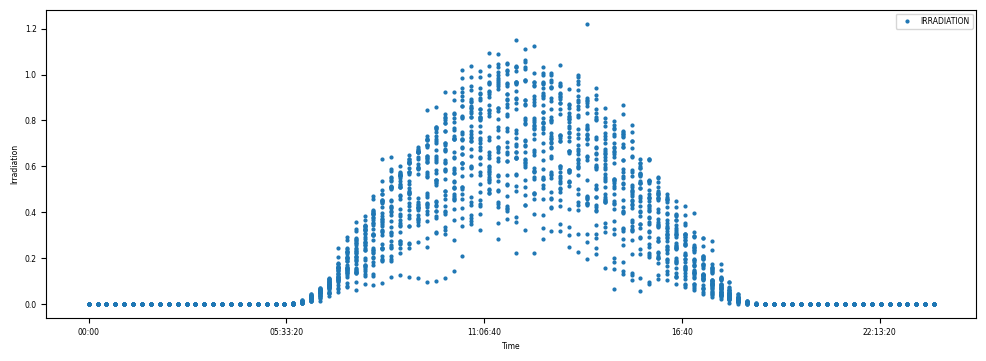

In [15]:
axs = daily_scatter_plot(df_power, True, 5)
df_irradiation = df_weather.loc[:, ['DATE_TIME', 'IRRADIATION']]
df_irradiation ['IRRADIATION']*=10000
df_irradiation.loc[:, 'time'] = df_irradiation['DATE_TIME'].dt.time
df_percentile_low  = df_irradiation.groupby(['time']).quantile(0.05).mean(axis = 1, numeric_only=True).reset_index()
df_percentile_low.columns = ['time', '5th percentile']
df_percentile_low.plot(x ='time', y = '5th percentile', ax = axs, label = '5th percentile of irradiation times 10000')
plt.show()
fig, axs = plt.subplots(figsize=(12, 4)) 
df_weather ['time'] = df_weather ['DATE_TIME'].dt.time
df_weather.plot(x = 'time', y = 'IRRADIATION', ax = axs, style = 'o',  markersize=2)
df_weather.drop(columns = ['time'], inplace = True)
plt.xlabel('Time')
plt.ylabel('Irradiation')
plt.show()

This suggests that except for a very small fraction of power generation datapoints that are 0, the rest of variation in data is the result of changes in irradiation. Let's see which inverters are responsible for these outliers. 

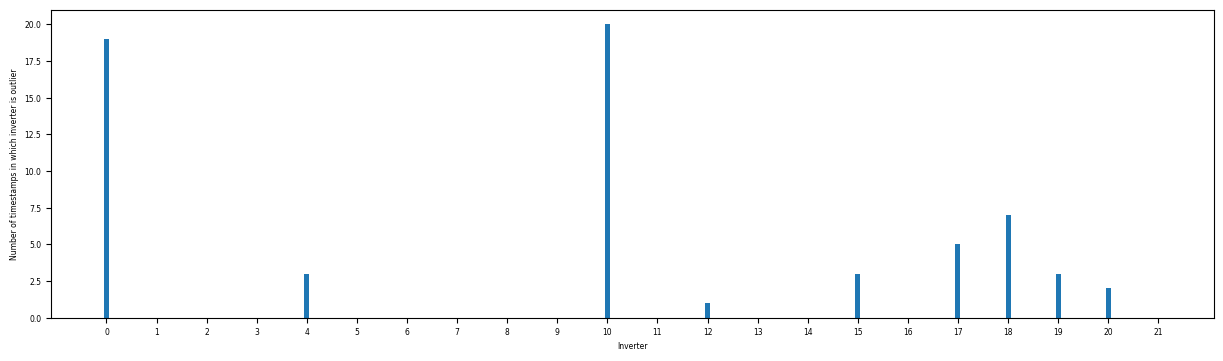

In [16]:
df_power ['day'] = df_power ['DATE_TIME'].dt.day
df_power ['hour'] = df_power  ['DATE_TIME'].dt.hour
df_power  ['minute'] =df_power ['DATE_TIME'].dt.minute+df_power ['hour']*60

low_outliers = [0]*22
for i in range(22):
        low_outliers[i] += len((df_power.loc[(df_power[f'DC_POWER_{i}']<1) & (df_power.minute>500) &(df_power.minute<1000)]))


plt.bar(range(22), low_outliers, width=0.1)
plt.xlabel('Inverter')
plt.xticks(range(22))
plt.ylabel('Number of timestamps in which inverter is outlier')
plt.show()

In [17]:
D = {}
for i in range (22):
    days = pd.unique(df_power.loc[(df_power[f'DC_POWER_{i}'] < 1)&(df_power.minute>500) &(df_power.minute<1000)]['day'])
    if len(days)>1:
        D[f'inverter_{i}'] = days

df_power = df_power.drop(columns = ['day', 'hour', 'minute'])

D

{'inverter_0': array([ 7, 14], dtype=int32),
 'inverter_10': array([ 7, 14], dtype=int32),
 'inverter_18': array([7, 9], dtype=int32),
 'inverter_19': array([24, 16], dtype=int32)}

It is likely that on the 7th day of June some inverteres were taken for maintanance. Other days could be due to need for maintanance as well. 
If the data was over a longer period, we would identify the patterns. In general, since these outliers were probably not the result of bad data, we don't remove them. 

We split the data into train and test. We leave the last 5 days for test. 

In [18]:
TRAIN_END_HR = 9
train_end = f'2020-06-12 0{TRAIN_END_HR}:00:00'
train_end_day = 12
data_end = '2020-06-16 00:00:00'
data_end_day = 17
df_train_power = df_power.loc[df_power.DATE_TIME < train_end].loc[:,:]
df_train_weather = df_weather.loc[df_weather.DATE_TIME < train_end].loc[:,:]
df_test_power = df_power.loc[df_power.DATE_TIME >= train_end].loc[:,:]
df_test_weather = df_weather.loc[df_weather.DATE_TIME >= train_end].loc[:,:]

We impute the data using linear interpolation. For the time intervals that are during the night, we set the missing values of power generation and irradiation to 0.  

In [19]:
def interpolate_night(df_in):
    df_in ['hour'] = df_in ['DATE_TIME'].dt.hour
    df_in_night  = df_in.loc[(df_in.hour<6)| (df_in.hour>18)]
    df_in_day  = df_in.loc[(df_in.hour>=6)& (df_in.hour<=18)]
    df_in_night = df_in_night.ffill()
    df_in = pd.concat([df_in_day, df_in_night])
    df_in = df_in.drop(columns = 'hour')
    return df_in
    
def interpolate(df_in):
    df_in = df_in.interpolate()
    return df_in.fillna(0)
    
df_train_power = interpolate (interpolate_night(df_train_power))
df_train_weather_irradiation = interpolate_night (df_train_weather.loc[:,['DATE_TIME', 'IRRADIATION']])
df_train_weather.loc[:, ['DATE_TIME', 'IRRADIATION']] = df_train_weather_irradiation
df_train_weather = interpolate (df_train_weather)
df_test_power = interpolate (interpolate_night(df_test_power))
df_test_weather_irradiation = interpolate_night (df_test_weather.loc[:,['DATE_TIME', 'IRRADIATION']])
df_test_weather.loc[:, ['DATE_TIME', 'IRRADIATION']] = df_test_weather_irradiation
df_test_weather = interpolate (df_test_weather)

#merge power and weather dataframes 
df_train = df_train_power.merge(df_train_weather, on = 'DATE_TIME', how ='outer')
df_test = df_test_power.merge(df_test_weather, on = 'DATE_TIME', how ='outer')

<Axes: xlabel='Time', ylabel='DC power'>

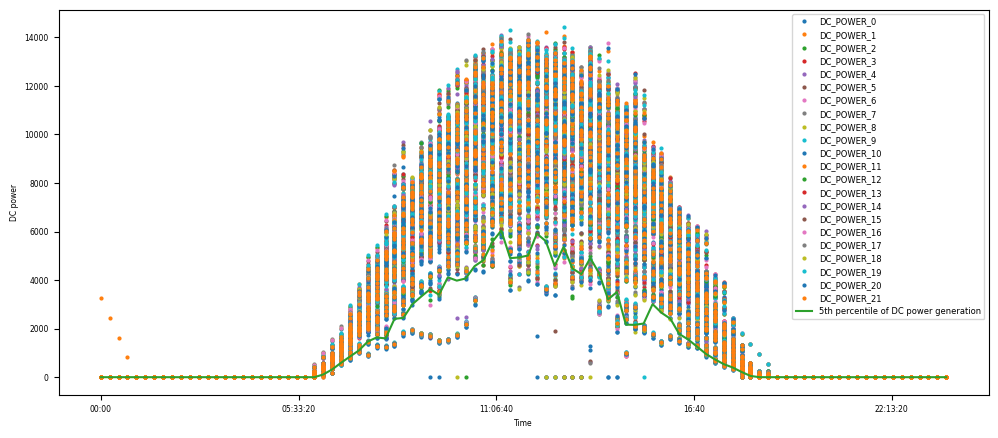

In [20]:
daily_scatter_plot(df_train, True)

## FORECASTING: ARIMA

Now, we decrease the resolution of the timestamps. 

<Axes: xlabel='Time', ylabel='DC power'>

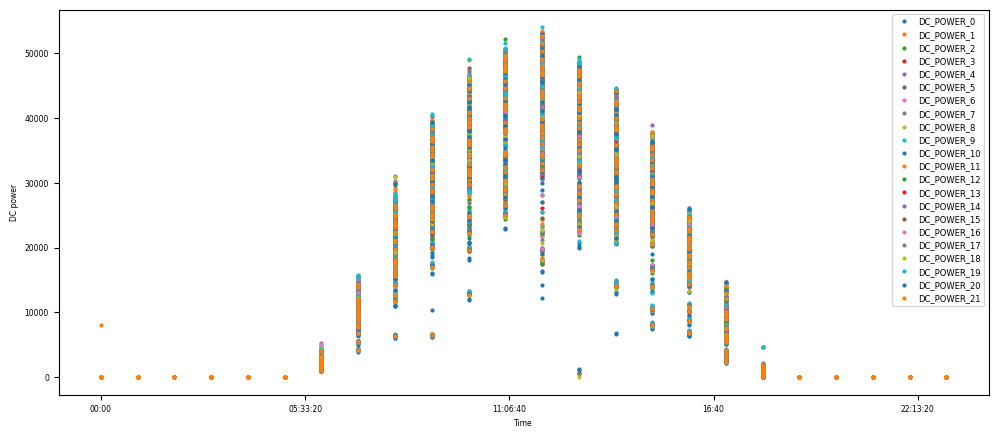

In [21]:
def down_sample (df_in, s):
    df_sum = df_in.drop (columns = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'])
    df_mean = df_in [['DATE_TIME','AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']]
    df_sum = df_sum.resample(s, on='DATE_TIME').sum()
    df_mean= df_mean.resample(s, on='DATE_TIME').mean()
    df_out = df_sum.merge(df_mean, on='DATE_TIME').reset_index()
    return df_out

df_train_downsample_1h = down_sample (df_train, '1h')
df_test_downsample_1h = down_sample(df_test, '1h')

daily_scatter_plot(df_train_downsample_1h)

In [22]:
#add a column for total DC power 

def total_DC_power (df_in):
    df_in['DC_POWER'] = df_in['DC_POWER_0']
    for i in range (1, 22):
        df_in ['DC_POWER']+= df_in[f'DC_POWER_{i}']

total_DC_power(df_train)
total_DC_power(df_train_downsample_1h)
total_DC_power(df_test)
total_DC_power(df_test_downsample_1h)

Let's plot the total DC power for the downsampled data.

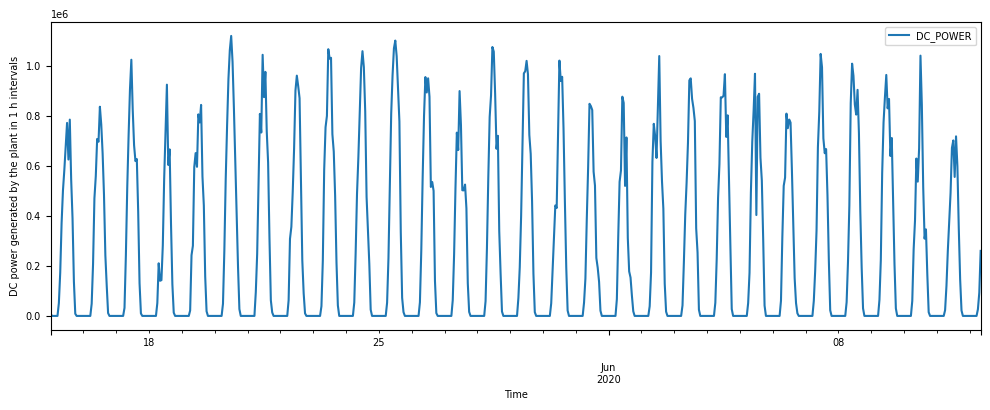

In [23]:
plt.rc('font',size=7)
plt.rc('figure',figsize=(12, 4))
df_train_downsample_1h.plot(x = 'DATE_TIME', y = 'DC_POWER')
plt.xlabel('Time')
plt.ylabel('DC power generated by the plant in 1 h intervals')
plt.show()

We perform an ADF test to test for stationarity. Our null hypothesis is that there a unit root in an AR model. 

In [24]:
adfuller(df_train_downsample_1h['DC_POWER'].values)

(-5.437301804980911,
 2.8268183621185623e-06,
 20,
 660,
 {'1%': -3.440296841949105,
  '5%': -2.8659291016222834,
  '10%': -2.569107357667585},
 16903.6256253636)

Since the p-value is very small, the null hypothesis is rejected and the time series could be considered stationary. 
Therefore we expect d=0 in our ARIMA model
Next, we perform an OCSB test to test whether the seasonal pattern is stable. 

In [25]:
OCSBTest(m=24).estimate_seasonal_differencing_term(df_train_downsample_1h["DC_POWER"])

0

The test recommends 0 as that the order of seasonal differencing. Therefore, we consider a determinisitc daily seasonality. We perform a  seasonal decomposition and remove the deterministic seasonality. 

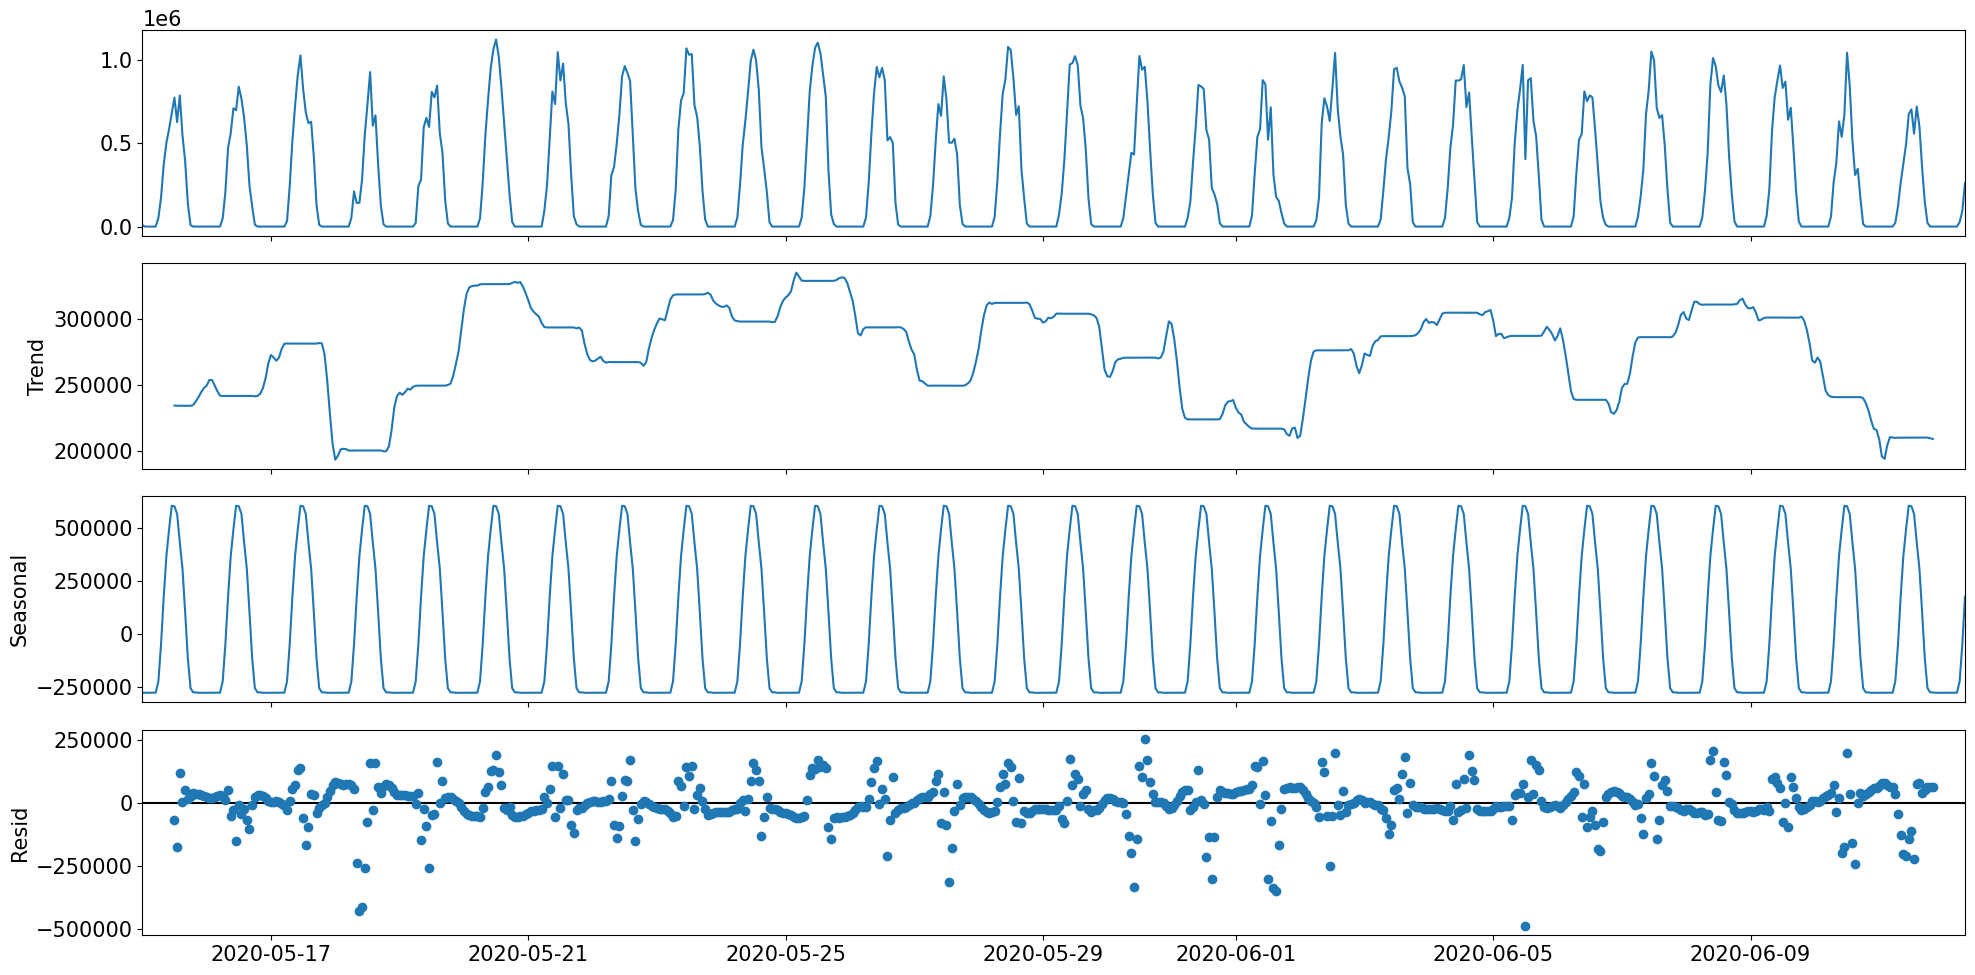

In [26]:
y = df_train_downsample_1h[['DC_POWER','DATE_TIME']]
y = y.groupby('DATE_TIME').sum()
y = y.asfreq(freq='1H') 
plt.rc('figure',figsize=(20,10))
plt.rc('font',size=15)
decompose = seasonal_decompose(y, model='additive')
fig = decompose.plot()

We plot the ACF and PACF of the time series after removing the seasonality. 

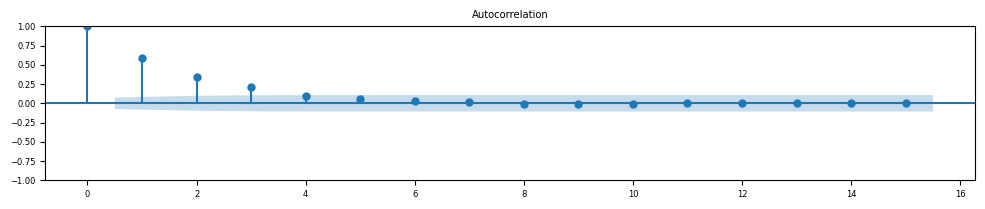

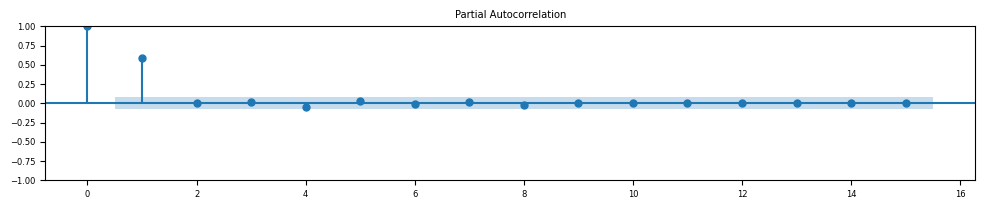

In [27]:
plt.rc('font',size=6)
plt.rc('figure',figsize=(12, 2))
y.loc[:, 'DC_POWER'] = y['DC_POWER'] -decompose.seasonal
plot_acf( y['DC_POWER'], lags = 15)
plot_pacf( y['DC_POWER'], lags = 15)
plt.show()

There seems to be a geometric decay in ACF and a sudden decay in PACF after 1. This suggests p = 1, q = 0. 

In [56]:
def arima (time_series, auto, order = None, seasonal_order = None):
    if auto:
        return auto_arima(time_series,
                          start_p=1, start_q=0,
                          max_p=3, max_q=2,
                          seasonal=True, m=24, 
                          error_action='warn',trace=True,
                          random=True,  random_state=20, n_fits=20 )
    else:
        return ARIMA(order, seasonal_order).fit(y)
arima_model = arima(y, auto = True)
arima_model

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=17229.872, Time=1.29 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=17510.588, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=17228.526, Time=1.31 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=17311.810, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=19057.644, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=17227.482, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=17227.934, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=17229.468, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=17229.476, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=17310.135, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=17231.475, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=17369.602, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[24] intercept
Total fit time: 3.617 seconds


ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 24),
      suppress_warnings=True)

Based on minimizing AIC, Autoarima gives ARIMA(1,0,0)(0,0,0), which is exactly as we expected.
Note that, by default, autoarima chooses d based on a kpss test (which gives the same result as the ADF test that we performed). 
Furthermore, it chooses D  based on an ocsb test that we performed earlier. 

Next, we use ARIMA(1,0,0)(0,0,0) to perform forecasting on the test set. Note that using an ARIMA model, it makes sense to retrain the model every day. 

In [63]:
def arima_predict (model, start_time, end_time, f):
    dates=pd.DataFrame(pd.date_range(start=start_time ,end= end_time ,freq=f))
    dates.columns = ['DATE_TIME']
    pred = pd.DataFrame(model.predict(n_periods = len(dates))).reset_index()
    pred = pred.drop(columns ='index')
    pred.columns= ['PRED']
    pred = pred.join(dates)
    return pred
arima_model = arima( df_train_downsample_1h ['DC_POWER'],  auto = False, order = (1,0,0), seasonal_order = (0,0,0,0))

pred = arima_predict(arima_model, train_end, '2020-06-'+str(train_end_day+1)+f' 0{TRAIN_END_HR-1}:00:00', '1h').set_index('DATE_TIME')

for i in range (train_end_day+1, data_end_day+1):
    start_day='2020-06-'+str(i)+ f' 0{TRAIN_END_HR}:00:00'
    end_day = '2020-06-'+str(i+1)+f' 0{TRAIN_END_HR-1}:00:00'
    df_train_reindex = df_train_downsample_1h.set_index('DATE_TIME')
    df_test_days_reindex = df_test_downsample_1h[df_test_downsample_1h.DATE_TIME<end_day].set_index('DATE_TIME')
    new_train = pd.concat([df_train_reindex, df_test_days_reindex ])
    arima_model = arima(new_train ['DC_POWER'],  auto = False, order = (1,0,0), seasonal_order = (0,0,0,0))
    pred_new_day = arima_predict(arima_model, start_day, end_day, '1h').set_index('DATE_TIME')
    pred = pd.concat([pred, pred_new_day])
arima_preds = pred.reset_index()

seasonal = pd.DataFrame(decompose.seasonal).iloc[TRAIN_END_HR:].reset_index()
arima_preds['PRED']= arima_preds['PRED']+seasonal['seasonal']
arima_preds ['hour'] = arima_preds['DATE_TIME'].dt.hour
arima_preds  = arima_preds [(arima_preds.hour >= TRAIN_END_HR) & (arima_preds.hour < 20)]

We plot the predication against the test. 

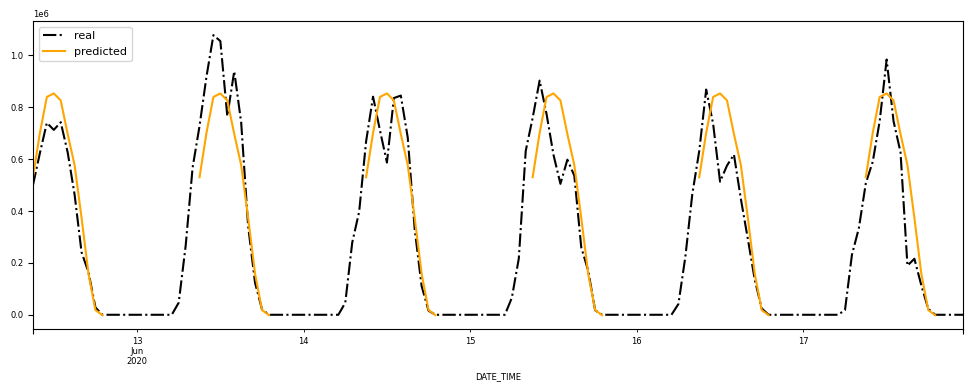

In [64]:
fig, axs = plt.subplots(figsize=(12, 4)) 
arima_preds ['day'] = arima_preds['DATE_TIME'].dt.day
df_test_downsample_1h.plot(x = 'DATE_TIME', y = 'DC_POWER', ax = axs, color ='black', style = '-.')
for i in range (train_end_day, data_end_day+1):
    pred_day = arima_preds [arima_preds.day == i]
    pred_day.plot(x = 'DATE_TIME', y = 'PRED', ax = axs, color = 'orange')
labels = pd.date_range(train_end, data_end, freq='6H')
plt.legend(['real', 'predicted'],fontsize = 8)
plt.show()

We compute the MSE of the ARIMA predictions. Later, we compare this to the MSE of the predictions of multilayer perceptron and LSTM.   

In [31]:
df_test_downsample_1h ['hour'] = df_test_downsample_1h['DATE_TIME'].dt.hour
df_test_arima_lim  = df_test_downsample_1h [(df_test_downsample_1h.hour >= TRAIN_END_HR) & (df_test_downsample_1h.hour < 20)]

MSE_arima = mean_squared_error(arima_preds.PRED, df_test_arima_lim.DC_POWER)
print(f'the MSE for ARIMA is  {MSE_arima}')

the MSE for ARIMA is  19483774613.20294


## FORECASTING: DEEP LEARNING

Now we will try two deep learning methods. One will be a standard multilayer perceptron, which is not designed with temporal data in mind, and the other will be an LSTM, which is explicitly designed for that purpose. In some cases, especially with relatively few features at each timestamp (as in this dataset), one can expect these two approaches to have similar performance.

In a bit more detail, both networks will be attempting to solve the same regression problem: given N days worth of input features, predict the next day of the same features. The multilayer perceptron will receive as input vectors of length N*num_features, reading them all at once and processing them as if they were one large feature vector. On the other hand, the LSTM will receive a matrix with N rows and num_features columns, and it will then read each row in sequence, updating its own internal state in order to come up with a final prediction.

Next, we have a function to normalize a dataframe's columns. The mean and standard deviation parameters are used when train=False so that we can reuse the train statistics for normalizing test data.

In [32]:
def get_normalized_df(df_in, train=True, mean=None, std=None):
    df_in = df_in.drop(columns=['DATE_TIME'])
    extra_info = []
    if mean is None and std is None and train:
        df_in_mean = df_in.mean(0)
        df_in_std = df_in.std(0)
        df_in = (df_in - df_in_mean)/df_in_std
        extra_info.append(df_in_mean)
        extra_info.append(df_in_std)
    elif mean is None or std is None:
        raise ValueError('Must provide mean/std for test data normalization')
    else:
        df_in = (df_in - mean)/std
    return df_in, extra_info

def denormalize_preds(preds, mean, std):
    mean = np.array(mean).reshape((1,1,-1))
    std = np.array(std).reshape((1,1,-1))
    return preds*std + mean

The following cell defines some objects which help in training a neural network. They each have a "step" function that is called to take an action each time an epoch (full pass through the training data) is completed. EarlyStop ends training early after too long without improvement in validation score, and SaveBestModel saves the parameters each time the score improves.

In [33]:
class EarlyStop:
    def __init__(self, wait_n_epochs):
        self.wait_n_epochs = wait_n_epochs
        self.epochs_since_improvement = 0
        self.best_val_loss = np.inf

    def step(self, val_loss):
        if self.best_val_loss > val_loss:
            self.best_val_loss = val_loss
            self.epochs_since_improvement = 0
            return False
        else:
            self.epochs_since_improvement += 1
            should_stop = (self.epochs_since_improvement >= self.wait_n_epochs)
            return should_stop

class SaveBestModel:
    def __init__(self, model, path):
        self.best_val_loss = np.inf
        self.model = model
        self.path = path

    def step(self, val_loss):
        if self.best_val_loss > val_loss:
            self.best_val_loss = val_loss
            torch.save(self.model.state_dict(), self.path)
            return True
        return False

Next we define the multilayer perceptron. It applies linear layers with a ReLU activation.

Recall that inputs to this network will be vectors with length (number of features)*(number of timestamps per input).

In [34]:
class NNSimple(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.lin1 = nn.Linear(in_shape[0], 64)
        self.lin2 = nn.Linear(64, 256)
        self.lin3 = nn.Linear(256, 128)
        self.lin4 = nn.Linear(128, out_shape[0])

    def forward(self,x):
        o = nn.functional.relu(self.lin1(x))
        o = nn.functional.relu(self.lin2(o))
        o = nn.functional.relu(self.lin3(o))
        o = self.lin4(o)
        return o

The LSTM takes sequences of vectors of length n_features.

In [35]:
class LSTMNetwork(nn.Module):
    def  __init__(self, in_shape, out_shape):
        super().__init__()
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.hidden_size = 128
        self.lstm = nn.LSTM(input_size=in_shape[1], hidden_size=self.hidden_size, num_layers=1, batch_first=True)
        self.lin1 = nn.Linear(self.hidden_size, 64)
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128, out_shape[0]) 
    def forward(self,x):
        _, (o, _) = self.lstm(x)
        o = nn.functional.relu(o)
        o = nn.functional.relu(self.lin1(o))
        o = nn.functional.relu(self.lin2(o))
        return self.lin3(o)

With the networks defined, the next cells create functions that facilitate a training process. In order to use the time series data as input to a neural network, it must processed to generate a datset of PyTorch tensors. The steps to do this are broken into the following steps:

**group_feats_into_seqs**:
In this function, the input dataframe is converted from a single time series into sub-sequences of a specified length (we will use 3 days of input data to generate predictions over the following day).

**train_val_split**:
Once the sequences are generated, a specified number of input-output pairs are set aside to periodically evaluate the model's performance.

**get_dataloaders**:
Dataloaders are PyTorch utility objects that abstract batching of input data. Using these, we can loop through the entire train dataset as many times (epochs) as desired, and it will shuffle the order of the data each time.

In [36]:
def group_feats_into_seqs(df_in, seq_len_in, seq_len_out, flat):
    numpy_features = np.array(df_in)
    n_features = numpy_features.shape[1]
    total_number_tsteps = numpy_features.shape[0]
    n_seqs = total_number_tsteps - seq_len_in - seq_len_out
    
    if not flat:
        x_seqs = np.zeros((n_seqs, seq_len_in, n_features))
        y_seqs = np.zeros((n_seqs, seq_len_out, n_features))
    else:
        x_seqs = np.zeros((n_seqs, seq_len_in*n_features))
        y_seqs = np.zeros((n_seqs, seq_len_out*n_features))

    for t in range(n_seqs):
        if not flat:
            x_seqs[t, ...] = numpy_features[t:(t+seq_len_in), ...]
            y_seqs[t, ...] = numpy_features[(t+seq_len_in):(t+seq_len_in+seq_len_out), ...]
        else:
            x_seqs[t, ...] = numpy_features[t:(t+seq_len_in), ...].ravel()
            y_seqs[t, ...] = numpy_features[(t+seq_len_in):(t+seq_len_in+seq_len_out), ...].ravel()
    return x_seqs, y_seqs

In [37]:
def train_val_split(df_in, val_tsteps, seq_length_in, seq_length_out, flat=False):
    # generate inputs for the neural networks
    x_seqs, y_seqs = group_feats_into_seqs(df_in, seq_length_in, seq_length_out, flat)

    # make sure val and train do not overlap
    train_inputs = x_seqs[:-(val_tsteps+seq_length_out),...]
    train_outputs = y_seqs[:-(val_tsteps+seq_length_out),...]
    val_inputs = x_seqs[-val_tsteps:,...]
    val_outputs = y_seqs[-val_tsteps:,...]

    # convert to tensors for use with neural networks
    train_inputs = torch.FloatTensor(train_inputs)
    train_outputs = torch.FloatTensor(train_outputs)
    val_inputs = torch.FloatTensor(val_inputs)
    val_outputs = torch.FloatTensor(val_outputs)

    return train_inputs, train_outputs, val_inputs, val_outputs

def get_dataloaders(train_x, train_y, val_x, val_y):
    train_ds = tdata.TensorDataset(train_x, train_y)
    val_ds = tdata.TensorDataset(val_x, val_y)
    return tdata.DataLoader(train_ds, batch_size=64, shuffle=True), \
            tdata.DataLoader(val_ds, batch_size=128, shuffle=False)

The training routine is very standard for most neural network applications. Train data is presented to the model in batches, and after each batch the accumulated errors are "back-propagated" to adjust network parameters in order to improve performance. After each epoch the validation set, which the model does not use to adjust its parameters, is used to estimate generalization error. The model with the best generalization according to this metric is saved to the specified path and returned, along with the sequence of validation errors.

In [38]:
def neuralnet_train(df_in, model_cls, model_out_path, lr, val_tsteps, seq_len_in, seq_len_out, wait_n_epochs_earlystop=10, n_epoch=50):
    # split into train and val data
    model_input_flat = (model_cls==NNSimple)
    train_x, train_y, val_x, val_y = train_val_split(df_in, val_tsteps, seq_len_in, seq_len_out, model_input_flat)

    model_in_size = train_x.size()[1:]
    model_out_size = [np.prod(train_y.size()[1:])]

    model = model_cls(model_in_size, model_out_size)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    train_dl, val_dl = get_dataloaders(train_x, train_y, val_x, val_y)

    # next part is to run a training loop
    val_losses = []
    early_stopper = EarlyStop(wait_n_epochs_earlystop)
    model_saver = SaveBestModel(model, model_out_path)
    for epoch in range(n_epoch):
        if epoch % 50 == 0:
            print(f'Training epoch {epoch}...\t(Best loss: {early_stopper.best_val_loss:.4e})')

        # train epoch
        for x_batch, y_batch in train_dl:
            opt.zero_grad()
            out = model(x_batch)
            loss_value = loss(out, y_batch.reshape(out.size()))
            loss_value.backward()
            opt.step()

        # compute validation score
        with torch.no_grad():
            val_total = 0
            n_seqs_seen = 0
            for x_batch, y_batch in val_dl:
                out = model(x_batch)
                val_total += loss(out, y_batch.reshape(out.size())).item()
                n_seqs_seen += x_batch.size(0)
        val_loss_per_seq = val_total/n_seqs_seen

        # check early stopping, save model if improvement
        val_losses.append(val_loss_per_seq)
        if early_stopper.step(val_losses[-1]):
            print(f'No improvement for {early_stopper.wait_n_epochs} epochs. Stopping after epoch {epoch}.')
            break
        model_saver.step(val_losses[-1])

    # load best model to return
    with torch.no_grad():
        best_model = model_cls(model_in_size, model_out_size)
        best_model.load_state_dict(torch.load(model_out_path)) # load best model
    return best_model, val_losses

Once the network is trained, it can be used to generate predictions on any dataframe:

In [39]:
def neuralnet_predict(df_in, model_cls, model_file_path, seq_len_in, seq_len_out, tsteps_per_day):
    model_flat = (model_cls==NNSimple)

    numpy_features = np.array(df_in)
    n_features = numpy_features.shape[1]
    n_tsteps = numpy_features.shape[0]

    if model_flat:
        model_in_size = [seq_len_in*n_features]
    else:
        model_in_size = [seq_len_in, n_features]

    model_out_size = [seq_len_out*n_features]
    model = model_cls(model_in_size, model_out_size)
    with torch.no_grad():
        model.load_state_dict(torch.load(model_file_path)) # load best model
        inputs = []
        st = 0
        while st <= (n_tsteps - seq_len_in - seq_len_out):
            if model_flat:
                inpt = numpy_features[st:(st+seq_len_in), ...].ravel()
            else:
                inpt = numpy_features[st:(st+seq_len_in), ...]
            inputs.append(torch.FloatTensor(inpt))
            st += tsteps_per_day
        return np.stack([model(inpt).numpy().reshape(seq_len_out, n_features) for inpt in inputs])

The following cells train a multilayer perceptron and an LSTM. Note that the training data feature means and standard deviations are saved to use when evaluating the models on test data.

The following cells train a multilayer perceptron and an LSTM. Note that the training data feature means and standard deviations are saved to use when evaluating the models on test data.

In [40]:
day_len = 24
# 3*day_len + teh + seq_len_out + buffer_len = 4*day_len
# teh + seq_len_out + buffer_len = day_len
# seq_len_out = day_len - teh - buffer_len
buffer_len = day_len + TRAIN_END_HR - 20 # 20=8pm
seq_len_in = 3*day_len + TRAIN_END_HR
seq_len_out = 20 - TRAIN_END_HR
val_days = 5

In [41]:
# create test dataframes for nns that need more input data to generate predictions
day_offs = train_end_day-(seq_len_in+TRAIN_END_HR)//day_len
train_end_nn = f"2020-06-{('0' if (day_offs < 10) else '') + str(day_offs)} 00:00:00"
df_test_power_nn = df_power.loc[df_power.DATE_TIME >= (train_end_nn)].loc[:,:]
df_test_weather_nn = df_weather.loc[df_weather.DATE_TIME >= (train_end_nn)].loc[:,:]

df_test_power_nn = interpolate (interpolate_night(df_test_power_nn))
df_test_weather_irradiation_nn = interpolate_night (df_test_weather_nn.loc[:,['DATE_TIME', 'IRRADIATION']])
df_test_weather_nn.loc[:, ['DATE_TIME', 'IRRADIATION']] = df_test_weather_irradiation_nn
df_test_weather_nn = interpolate (df_test_weather_nn)

#merge power and weather dataframes 
df_test_nn = df_test_power_nn.merge(df_test_weather_nn, on = 'DATE_TIME', how ='outer')

df_test_nn_downsample_1h = down_sample(df_test_nn, '1H')
total_DC_power(df_test_nn_downsample_1h)

In [42]:
df_train_normalized, [means, stds] = get_normalized_df(df_train_downsample_1h)
df_test_normalized, _ = get_normalized_df(df_test_nn_downsample_1h, train=False, mean=means, std=stds)

In [43]:
simplenn_model, simplenn_losses = neuralnet_train(df_train_normalized, NNSimple, 'nn.pth', 5e-5, val_days*day_len, seq_len_in, seq_len_out, wait_n_epochs_earlystop=50, n_epoch=1000)
lstm_model, lstm_losses = neuralnet_train(df_train_normalized, LSTMNetwork, 'lstm.pth', 1e-4, val_days*day_len, seq_len_in, seq_len_out, wait_n_epochs_earlystop=50, n_epoch=1000)

Training epoch 0...	(Best loss: inf)
Training epoch 50...	(Best loss: 9.0287e-04)
Training epoch 100...	(Best loss: 8.0001e-04)
Training epoch 150...	(Best loss: 7.8247e-04)
Training epoch 200...	(Best loss: 7.7804e-04)
No improvement for 50 epochs. Stopping after epoch 204.
Training epoch 0...	(Best loss: inf)
Training epoch 50...	(Best loss: 1.1678e-03)
Training epoch 100...	(Best loss: 8.3689e-04)
Training epoch 150...	(Best loss: 7.7261e-04)
Training epoch 200...	(Best loss: 7.5900e-04)
No improvement for 50 epochs. Stopping after epoch 231.


Now that the models are trained, we compute their predictions on unseen test data and undo the normalization we performed earlier so that we can compare their performance to ARIMA.

In [45]:
test_preds_lstm = neuralnet_predict(df_test_normalized, LSTMNetwork, 'lstm.pth', seq_len_in, seq_len_out, day_len)
test_preds_nnsimple = neuralnet_predict(df_test_normalized, NNSimple, 'nn.pth', seq_len_in, seq_len_out, day_len)

In [46]:
denormed_test_preds_lstm = denormalize_preds(test_preds_lstm, means, stds)
denormed_test_preds_nnsimple = denormalize_preds(test_preds_nnsimple, means, stds)

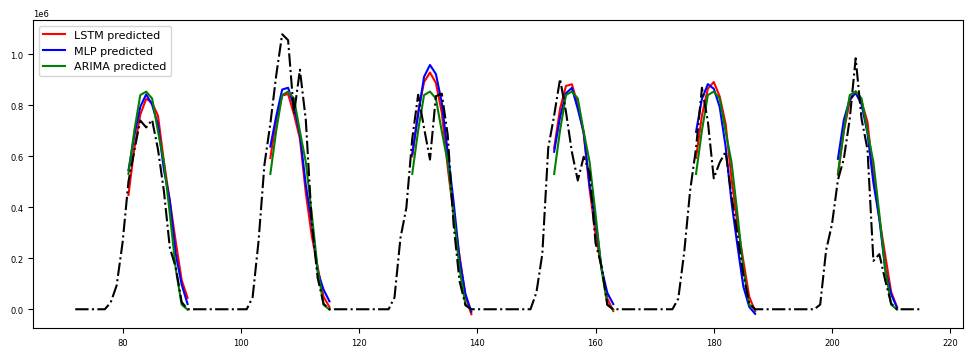

In [78]:
fig, axs = plt.subplots(figsize=(12, 4)) 
plot_var_idx = np.argmax(df_test_normalized.columns=='DC_POWER')
MSE_lstm = 0
MSE_nnsimple = 0
for i in range(denormed_test_preds_lstm.shape[0]):
    x_vals_i = seq_len_in + 24*i + np.arange(denormed_test_preds_lstm.shape[1])
    lstm_pred = denormed_test_preds_lstm[i, :, plot_var_idx]
    nnsimple_pred = denormed_test_preds_nnsimple[i, :, plot_var_idx]
    start_day='2020-06-'+str(train_end_day+i)+ f' 0{TRAIN_END_HR}:00:00'
    end_day = '2020-06-'+str(train_end_day+i)+' 20:00:00'
    df_test_lim = df_test_nn_downsample_1h[(df_test_nn_downsample_1h.DATE_TIME>=start_day) & (df_test_nn_downsample_1h.DATE_TIME<end_day)]
    df_preds_lim = arima_preds[(arima_preds.DATE_TIME>=start_day) & (arima_preds.DATE_TIME<end_day)]
    MSE_lstm += mean_squared_error(lstm_pred, df_test_lim.DC_POWER)
    MSE_nnsimple +=mean_squared_error(nnsimple_pred, df_test_lim.DC_POWER)
    plt.plot(x_vals_i, lstm_pred, 'r')
    plt.plot(x_vals_i, nnsimple_pred, 'b')
    plt.plot(x_vals_i, df_preds_lim['PRED'], 'g')
df_test_nn_lim = df_test_nn_downsample_1h [ df_test_nn_downsample_1h.DATE_TIME >= '2020-06-'+str(train_end_day)+ f' 00:00:00']
plt.plot(df_test_nn_lim['DC_POWER'], 'k-.')

plt.legend(['LSTM predicted', 'MLP predicted', 'ARIMA predicted'],fontsize = 8)
plt.show()

In [79]:
print(f'the MSE for LSTM {MSE_lstm/6}')
print(f'the MSE for MLP  {MSE_nnsimple/6}')
print(f'the MSE for ARIMA  {MSE_arima}')

the MSE for LSTM 19379673450.579678
the MSE for MLP  17446762759.681942
the MSE for ARIMA  19483774613.20294


The MLP does noticeably better than both LSTM and ARIMA. One reason for this might be that its input is formatted so that it considers all times at once, whereas the LSTM and ARIMA must process each time stamp in order. With access to more computational resources, we could perform a thorough hyperparameter search for the neural network models to get a better idea of what the limiting factors on performance are. A significant amount of the error, however, is likely not possible to avoid given the limited data we have access to. More comprehensive weather data and predictions, in addition to simulation models of the PV cells, would be very helpful in making accurate forecasts.